<a href="https://colab.research.google.com/github/thewill-i-am/Quantum-Generative-Adversarial-Networks/blob/main/Quantum_Generative_Adversarial_Networks_Real_Integracion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
 !pip install qiskit qiskit-ibm-provider qiskit-ibm-runtime qiskit-machine-learning torch torchvision matplotlib pylatexenc


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 6.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 6.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 28.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 249.9/249.9 kB 15.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 28.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.8/97.8 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 340.8/340.8 kB 17.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.5/310.5 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 38.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 


Autor: William Aguilar-Calvo

En este tutorial, exploraremos las GANs cuánticas para generar dígitos escritos a mano del número cero. Primero cubriremos la teoría del caso clásico, y luego extenderemos el método a uno cuántico propuesto recientemente en la literatura. Si no tienes experiencia con GANs, especialmente en PyTorch, puede que encuentres útil el [tutorial de PyTorch](https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html), ya que sirve como base para lo que sigue.




In [ ]:
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter, ParameterVector
from qiskit.compiler import transpile
from qiskit_machine_learning.connectors import TorchConnector
from qiskit_machine_learning.neural_networks import SamplerQNN
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import SamplerV2 as Sampler
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

import math
import random
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec


Generative Adversarial Networks (GANs)
======================================


El objetivo de las redes generativas antagónicas (GANs) es generar datos que se asemejen a los datos originales utilizados en el entrenamiento. Para lograr esto, entrenamos dos redes neuronales simultáneamente: un generador y un discriminador. La tarea del generador es crear datos falsos que imiten el conjunto de datos de entrenamiento real. Por otro lado, el discriminador actúa como un detective que intenta discernir entre datos reales y falsos. Durante el proceso de entrenamiento, ambos jugadores mejoran iterativamente uno con respecto al otro. Al final, el generador debería, idealmente, generar nuevos datos muy similares al conjunto de datos de entrenamiento.

Específicamente, el conjunto de datos de entrenamiento representa muestras extraídas de una distribución de datos desconocida $P_{data}$, y el generador tiene la tarea de intentar capturar esta distribución. El generador, $G$, comienza desde alguna distribución latente inicial, $P_z$, y la mapea a $P_g = G(P_z)$. La mejor solución sería que $P_g = P_{data}$. Sin embargo, este punto rara vez se alcanza en la práctica, excepto en tareas muy simples.

Tanto el discriminador, $D$, como el generador, $G$, participan en un juego minimax de 2 jugadores. El discriminador intenta maximizar la probabilidad de discernir datos reales de los falsos, mientras que el generador intenta minimizar esa misma probabilidad. La función de valor para el juego se resume en,

$$
\begin{aligned}
\begin{align}
\min_G \max_D V(D,G) &= \mathbb{E}_{\boldsymbol{x}\sim p_{data}}[\log D(\boldsymbol{x})] \\
    & ~~ + \mathbb{E}_{\boldsymbol{z}\sim p_{\boldsymbol{z}}}[\log(1 - D(G(\boldsymbol{z}))]
\end{align}
\end{aligned}
$$

-   $\boldsymbol{x}:$ muestra de datos reales
-   $\boldsymbol{z}:$ vector latente
-   $D(\boldsymbol{x}):$ probabilidad de que el discriminador clasifique
    datos reales como reales
-   $G(\boldsymbol{z}):$ datos falsos
-   $D(G(\boldsymbol{z})):$ probabilidad de que el discriminador clasifique
    datos falsos como reales

En la práctica, las dos redes se entrenan iterativamente, cada una con una función de pérdida separada a minimizar,

$$
L_D = -[y \cdot \log(D(x)) + (1-y)\cdot \log(1-D(G(z)))]
$$

$$
L_G = [(1-y) \cdot \log(1-D(G(z)))]
$$

donde $y$ es una etiqueta binaria para datos reales ($y=1$) o falsos ($y=0$). En la práctica, se ha demostrado que el entrenamiento del generador es más estable cuando se le hace maximizar $\log(D(G(z)))$ en lugar de minimizar $\log(1-D(G(z)))$. Por lo tanto, la función de pérdida del generador a minimizar se convierte en,

$$
L_G = -[(1-y) \cdot \log(D(G(z)))]
$$

Scanear QR:

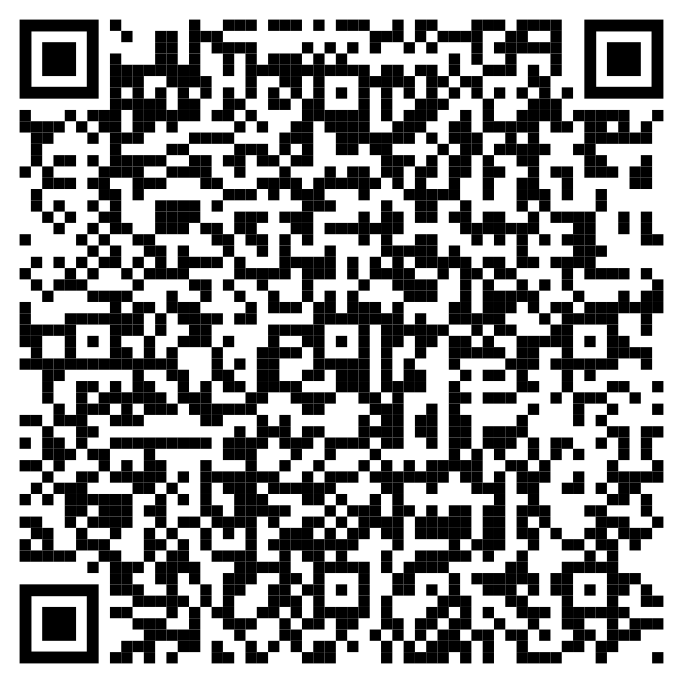



Conexión con computadora cuantica
======================================


Cambia el token por el de https://quantum.ibm.com/

In [ ]:
QiskitRuntimeService.save_account(channel="ibm_quantum", token="<YOUR TOKEN HERE>", overwrite=True, set_as_default=True)
service = QiskitRuntimeService(channel='ibm_quantum')
backend = service.least_busy(min_num_qubits=127)
sampler = Sampler(mode=backend)
print(backend)
print(f"Usando el backend: {backend}")

<IBMBackend('ibm_sherbrooke')>
Usando el backend: <IBMBackend('ibm_sherbrooke')>


Quantum GANs: The Patch Method
==============================



En este tutorial, recreamos uno de los métodos de GAN cuánticas presentado por Huang et al.: el método de parches. Este método utiliza varios generadores cuánticos, donde cada sub-generador, $G^{(i)},$ es responsable de construir un pequeño parche de la imagen final. La imagen final se construye concatenando todos los parches juntos como se muestra a continuación.

<p align="center">
  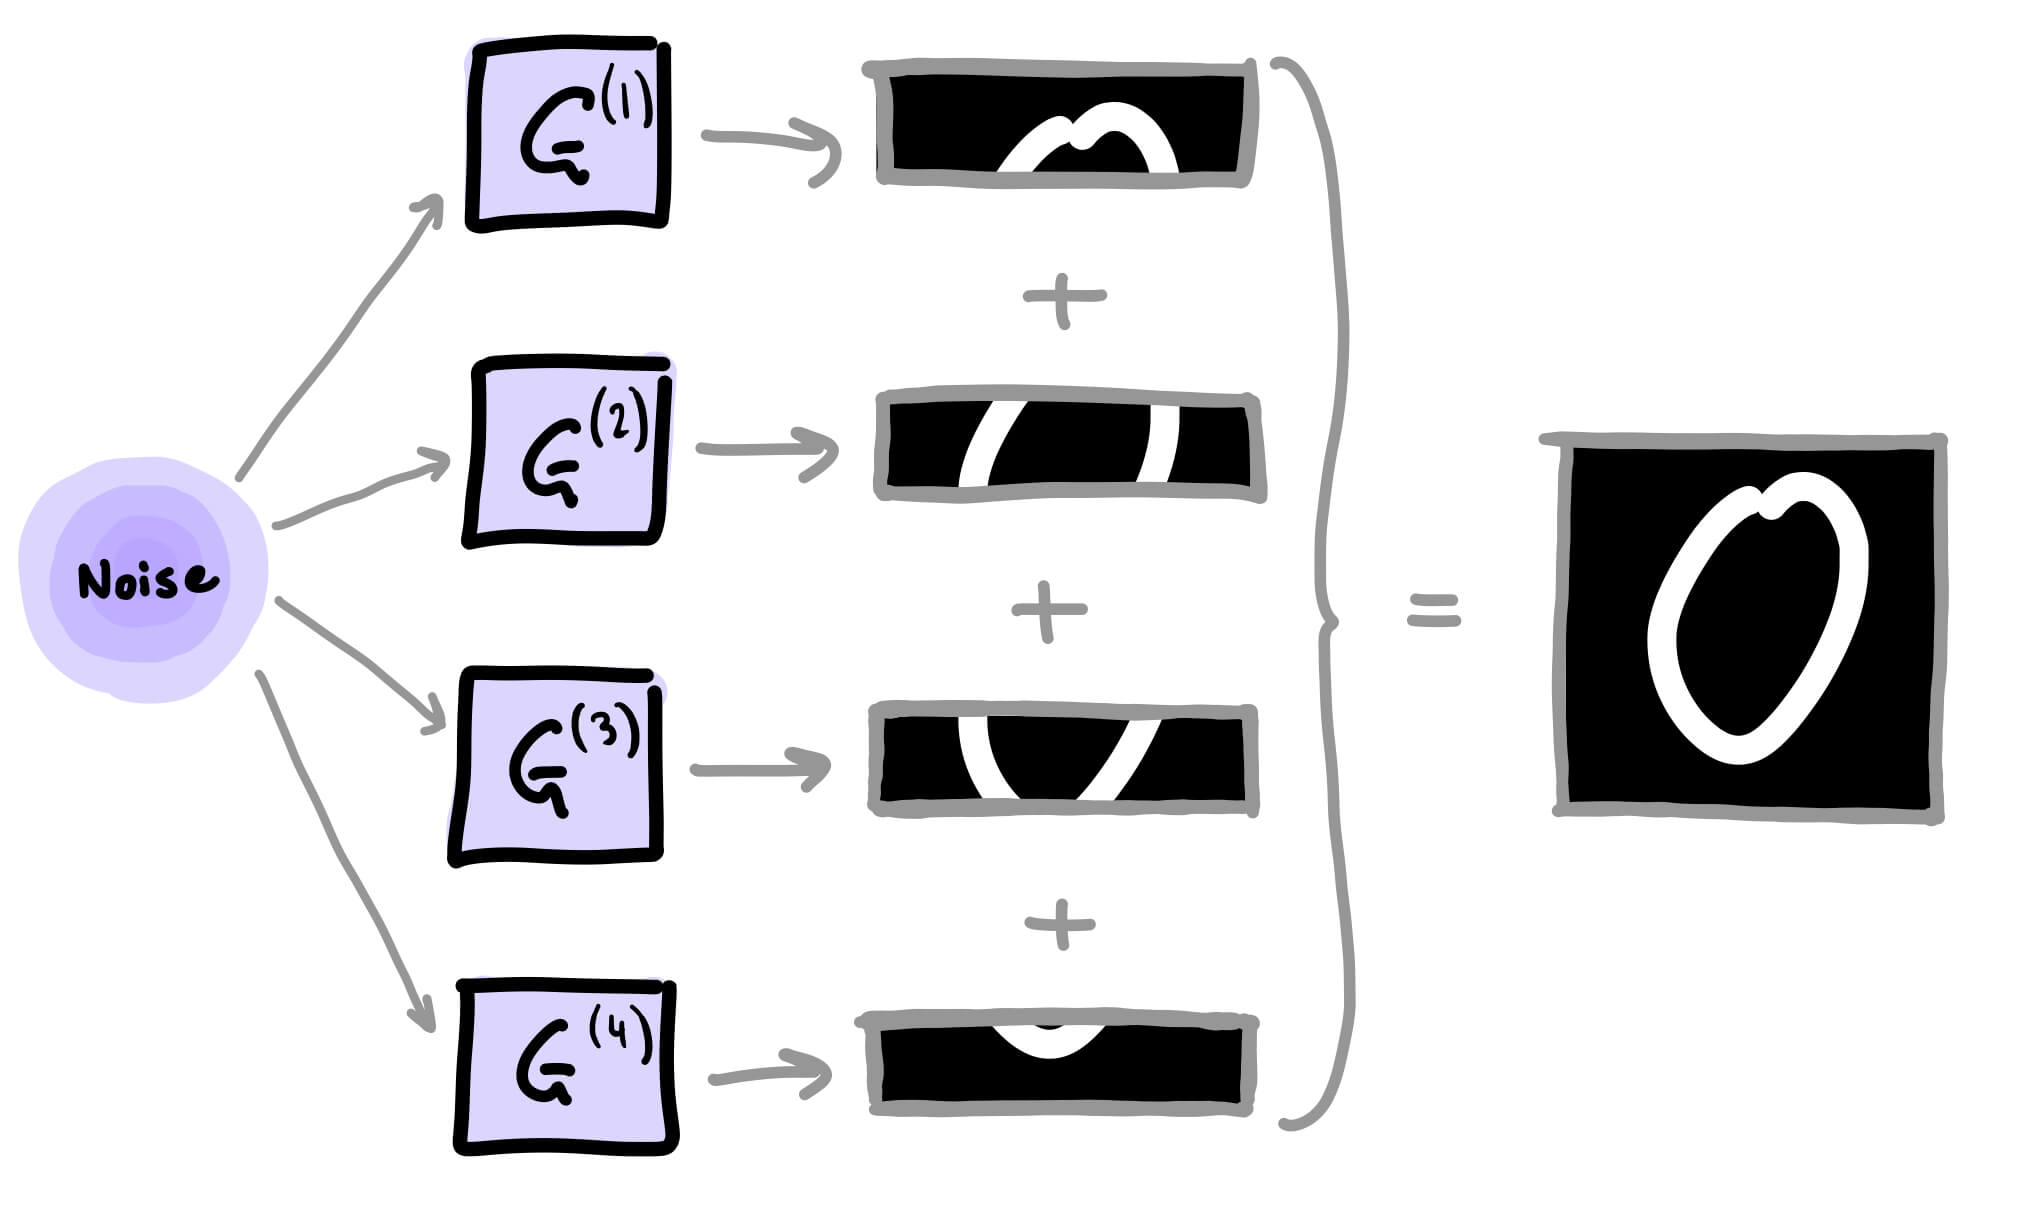
</p>

La principal ventaja de este método es que se adapta particularmente bien a situaciones donde el número de qubits disponibles es limitado. El mismo dispositivo cuántico puede ser utilizado para cada sub-generador de forma iterativa, o la ejecución de los generadores puede ser paralelizada en múltiples dispositivos.

> **Nota**  
> En este tutorial, se utilizan superíndices entre paréntesis para denotar objetos individuales como parte de una colección.


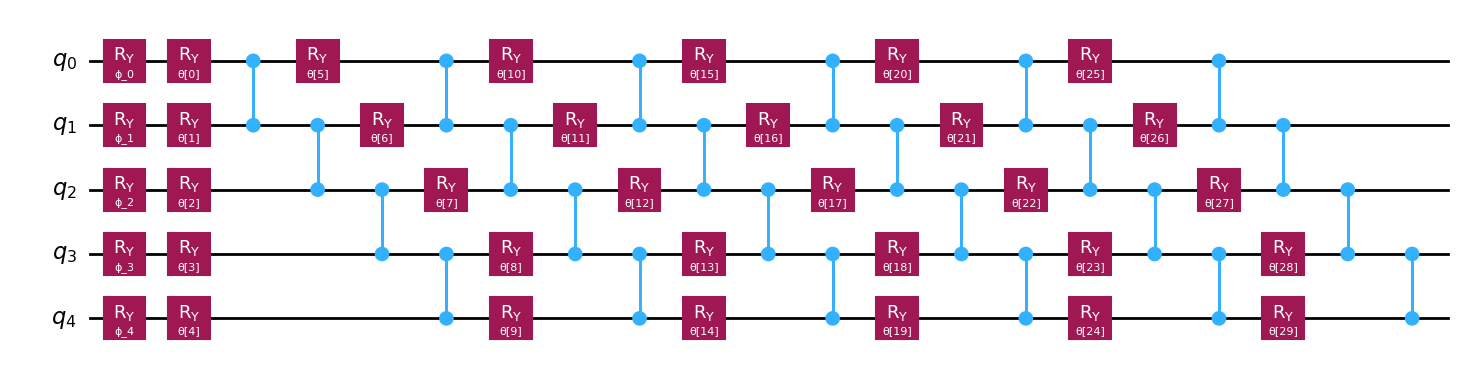

In [ ]:
# Definición de la función create_quantum_circuit
def create_quantum_circuit(n_qubits, depth, n_a_qubits=1):
    qc = QuantumCircuit(n_qubits)
    # Parámetros de entrada
    input_params = [Parameter(f'ϕ_{i}') for i in range(n_qubits)]
    for i in range(n_qubits):
        qc.ry(input_params[i], i)
    # Parámetros de peso
    weight_params = ParameterVector('θ', length=depth * n_qubits)
    param_idx = 0
    for _ in range(depth):
        for i in range(n_qubits):
            qc.ry(weight_params[param_idx], i)
            param_idx += 1
        for i in range(n_qubits - 1):
            qc.cz(i, i + 1)
    return qc, input_params, weight_params


from qiskit import QuantumCircuit
from qiskit.circuit import Parameter, ParameterVector
import matplotlib.pyplot as plt
n_qubits = 5
depth = 6
n_a_qubits = 1
qc, input_params, weight_params = create_quantum_circuit(n_qubits, depth, n_a_qubits)
fig = qc.draw(output='mpl')
fig.savefig('quantum_circuit.png')
qc.draw(output='mpl')


Implementing the Discriminator
==============================


Para el discriminador, utilizamos una red neuronal completamente conectada con dos
capas ocultas. Una sola salida es suficiente para representar la
probabilidad de que una entrada sea clasificada como real.

In [ ]:
class Discriminator(nn.Module):
    """Discriminador clásico completamente conectado"""

    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 16),
            nn.ReLU(),
            nn.Linear(16, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

Implementing the Generator
==========================


Cada sub-generador, $G^{(i)},$ comparte la misma arquitectura de circuito como se muestra a continuación. El generador cuántico general consiste en $N_G$ sub-generadores, cada uno compuesto por $N$ qubits. El proceso desde la entrada del vector latente hasta la salida de la imagen se puede dividir en cuatro secciones distintas: incrustación de estado, parametrización, transformación no lineal y post-procesamiento. Cada una de las siguientes secciones se refiere a una sola iteración del proceso de entrenamiento para simplificar la discusión.

<p align="center">
  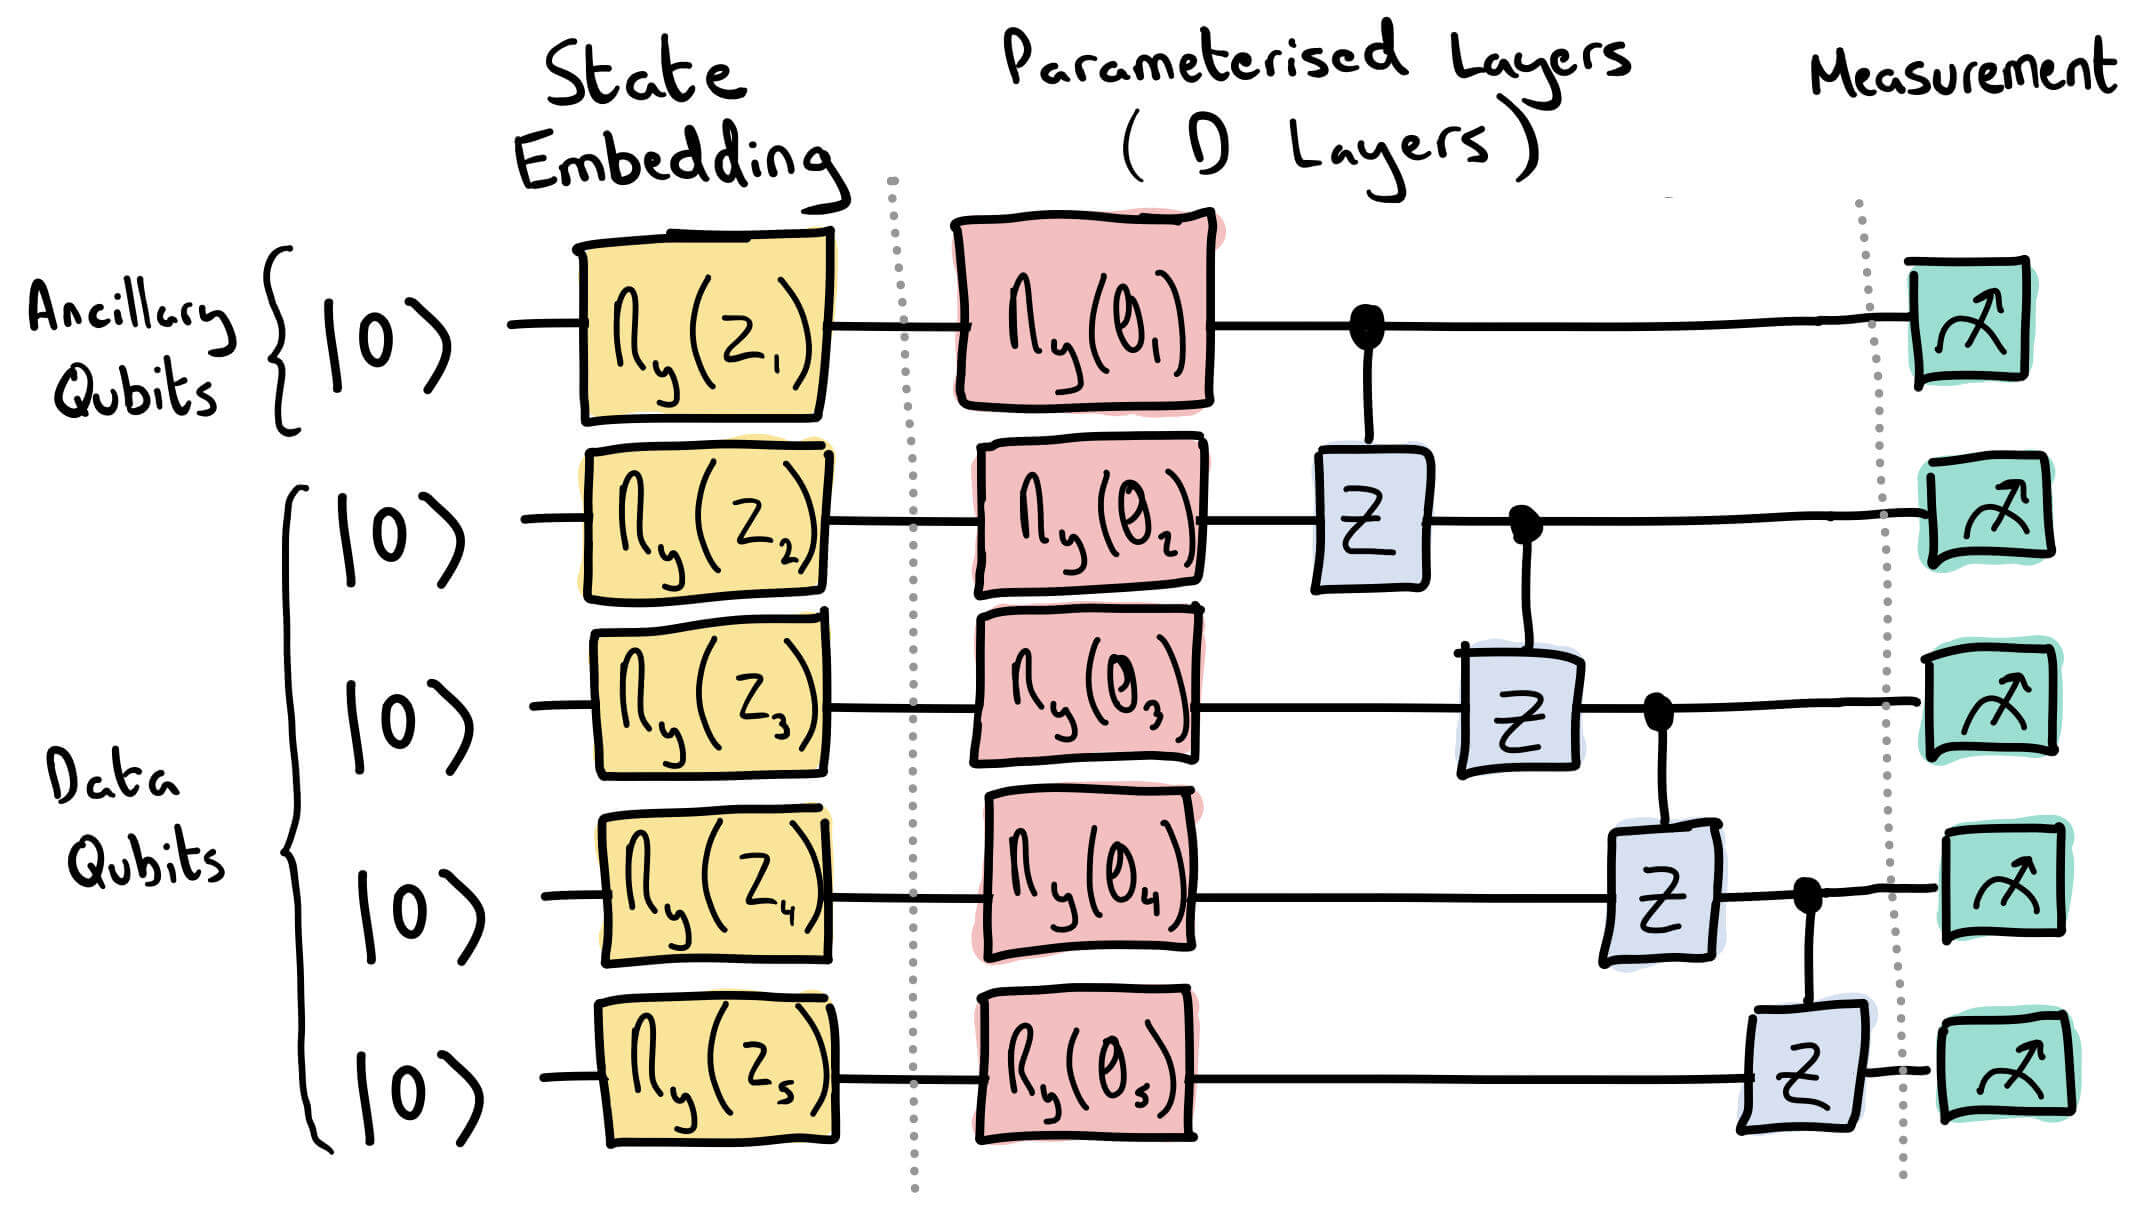
</p>

**1) Incrustación de Estado**

Un vector latente, $\boldsymbol{z}\in\mathbb{R}^N,$ se extrae de una distribución uniforme en el intervalo $[0,\pi/2).$ Todos los sub-generadores reciben el mismo vector latente, que luego es incrustado utilizando puertas RY.

**2) Capas Parametrizadas**

La capa parametrizada consiste en puertas RY parametrizadas seguidas de puertas Z controladas. Esta capa se repite un total de $D$ veces.

**3) Transformación No Lineal**

Las puertas cuánticas en el modelo de circuito son unitarias, lo cual, por definición, transforma linealmente el estado cuántico. Una asignación lineal entre la distribución latente y la distribución del generador solo sería suficiente para las tareas generativas más simples; por lo tanto, necesitamos transformaciones no lineales. Utilizaremos qubits auxiliares para ayudar en este proceso.

Para un sub-generador dado, el estado cuántico antes de la medición está dado por,

$$|\Psi(z)\rangle = U_{G}(\theta)|\boldsymbol{z}\rangle$$

donde $U_{G}(\theta)$ representa la unitaria general de las capas parametrizadas. Inspeccionemos el estado cuando tomamos una medición parcial, $\Pi,$ y eliminamos el subsistema auxiliar, $\mathcal{A},$

$$\rho(\boldsymbol{z}) = \frac{\text{Tr}_{\mathcal{A}}(\Pi \otimes \mathbb{I} |\Psi(z)\rangle \langle \Psi(\boldsymbol{z})|) }{\text{Tr}(\Pi \otimes \mathbb{I} |\Psi(\boldsymbol{z})\rangle \langle \Psi(\boldsymbol{z})|))} = \frac{\text{Tr}_{\mathcal{A}}(\Pi \otimes \mathbb{I} |\Psi(\boldsymbol{z})\rangle \langle \Psi(\boldsymbol{z})|) }{\langle \Psi(\boldsymbol{z})| \Pi \otimes \mathbb{I} |\Psi(\boldsymbol{z})\rangle}$$

El estado post-medición, $\rho(\boldsymbol{z}),$ depende de $\boldsymbol{z}$ tanto en el numerador como en el denominador. ¡Esto significa que el estado ha sido transformado de manera no lineal! Para este tutorial, $\Pi = (|0\rangle \langle0|)^{\otimes N_A},$ donde $N_A$ es el número de qubits auxiliares en el sistema.

Con los qubits de datos restantes, medimos la probabilidad de $\rho(\boldsymbol{z})$ en cada estado de la base computacional, $P(j),$ para obtener la salida del sub-generador, $\boldsymbol{g}^{(i)},$

$$\boldsymbol{g}^{(i)} = [P(0), P(1), ... ,P(2^{N-N_A} - 1)]$$

**4) Post-Procesamiento**

Debido a la restricción de normalización de la medición, todos los elementos en $\boldsymbol{g}^{(i)}$ deben sumar uno. Esto es un problema si queremos usar $\boldsymbol{g}^{(i)}$ como los valores de intensidad de píxeles para nuestro parche. Por ejemplo, imaginemos una situación hipotética en la que el objetivo es un parche de píxeles con intensidad total. El mejor parche que un sub-generador podría producir sería un parche de píxeles con una magnitud de $\frac{1}{2^{N-N_A}}$ en todos ellos. Para aliviar esta restricción, aplicamos una técnica de post-procesamiento a cada parche,

$$\boldsymbol{\tilde{x}^{(i)}} = \frac{\boldsymbol{g}^{(i)}}{\max_{k}\boldsymbol{g}_k^{(i)}}$$

Por lo tanto, la imagen final, $\boldsymbol{\tilde{x}},$ está dada por

$$\boldsymbol{\tilde{x}} = [\boldsymbol{\tilde{x}^{(1)}}, ... ,\boldsymbol{\tilde{x}^{(N_G)}}]$$

In [ ]:
class QuantumGenerator(nn.Module):
    """Generador cuántico utilizando Qiskit y TorchConnector"""

    def __init__(self, n_qubits, depth, n_a_qubits=1, sampler=None):
        super(QuantumGenerator, self).__init__()
        self.n_qubits = n_qubits
        self.depth = depth
        self.n_a_qubits = n_a_qubits

        # Crear el circuito cuántico y obtener los parámetros
        self.qc, self.input_params, self.weight_params = create_quantum_circuit(
            n_qubits, depth, n_a_qubits
        )

        # Definir el Sampler (usando el backend real si se proporciona)
        if sampler is None:
            self.sampler = sampler
        else:
            self.sampler = sampler

        # Definir el SamplerQNN
        self.qnn = SamplerQNN(
            sampler=self.sampler,
            circuit=self.qc,
            input_params=self.input_params,
            weight_params=self.weight_params,
            sparse=False
        )

        # Inicializar pesos
        initial_weights = 0.1 * (2 * torch.rand(len(self.weight_params)) - 1)
        self.torch_connector = TorchConnector(self.qnn, initial_weights=initial_weights)

    def forward(self, x):
        probs = self.torch_connector(x)  # Salida: (batch_size, 2^n_qubits)
        processed_probs = self.process_probs(probs)
        return processed_probs

    def process_probs(self, probs):
        n_total_qubits = self.n_qubits
        n_data_qubits = self.n_qubits - self.n_a_qubits

        # Generar las representaciones en bits de todos los estados base
        indices = torch.arange(2 ** n_total_qubits, device=probs.device)
        bitstrings = ((indices[:, None] >> torch.arange(n_total_qubits -1, -1, -1, device=probs.device)) & 1).long()

        # Obtener los bits correspondientes a los qubits ancilla y de datos
        ancilla_bits = bitstrings[:, -self.n_a_qubits:]  # Qubits ancilla
        data_bits = bitstrings[:, :n_data_qubits]  # Qubits de datos

        # Máscara donde los qubits ancilla están en estado |0⟩
        ancilla_zero_mask = (ancilla_bits.sum(dim=1) == 0)  # (2^n_qubits,)

        # Filtrar las probabilidades donde los qubits ancilla están en |0⟩
        probs_valid = probs[:, ancilla_zero_mask]  # (batch_size, num_valid_states)

        # Mapear los estados de los qubits de datos a índices
        valid_data_bits = data_bits[ancilla_zero_mask]  # (num_valid_states, n_data_qubits)
        data_state_indices = valid_data_bits.matmul(1 << torch.arange(n_data_qubits -1, -1, -1, device=probs.device))  # (num_valid_states,)

        # Inicializar tensor para las probabilidades procesadas
        batch_size = probs.shape[0]
        num_data_states = 2 ** n_data_qubits
        processed_probs = torch.zeros(batch_size, num_data_states, device=probs.device)

        # Expandir data_state_indices para que coincida con el batch_size
        data_state_indices = data_state_indices.unsqueeze(0).expand(batch_size, -1)  # (batch_size, num_valid_states)

        # Sumar las probabilidades correspondientes
        processed_probs.scatter_add_(1, data_state_indices, probs_valid)

        return processed_probs


Ahora creamos una clase de generador cuántico para usar durante el entrenamiento.

In [ ]:
class PatchQuantumGenerator(nn.Module):
    """Generador cuántico utilizando el método patch"""

    def __init__(self, n_generators, n_qubits, depth, n_a_qubits=1, sampler=None):
        super(PatchQuantumGenerator, self).__init__()
        self.n_generators = n_generators
        self.n_qubits = n_qubits
        self.generators = nn.ModuleList([
            QuantumGenerator(n_qubits, depth, n_a_qubits, sampler=sampler)
            for _ in range(n_generators)
        ])

    def forward(self, x):
        batch_size = x.shape[0]
        patches = []
        for gen in self.generators:
            # Generar parche
            patch = gen(x)
            # Post-procesamiento: normalizar el parche
            patch = patch / torch.max(patch, dim=1, keepdim=True)[0]
            patches.append(patch)
        # Concatenar todos los parches para formar la imagen completa
        generated_image = torch.cat(patches, dim=1)
        return generated_image


Data
====


Como se mencionó en la introducción, utilizaremos un [pequeño conjunto de datos](https://archive.ics.uci.edu/ml/datasets/optical+recognition+of+handwritten+digits) de ceros escritos a mano. Primero, necesitamos crear un cargador de datos personalizado para este conjunto de datos.


In [ ]:
class DigitsDataset(Dataset):
    """Dataloader de PyTorch para el conjunto de datos de reconocimiento óptico de dígitos escritos a mano"""

    def __init__(self, csv_file, label=0, transform=None):
        self.csv_file = csv_file
        self.transform = transform
        self.df = self.filter_by_label(label)

    def filter_by_label(self, label):
        df = pd.read_csv(self.csv_file, header=None)
        df = df.loc[df.iloc[:, -1] == label]
        return df

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        image = self.df.iloc[idx, :-1].values.astype(np.float32) / 16.0  # Normalizar los píxeles
        image = image.reshape(8, 8)  # Reshape a imagen 8x8

        if self.transform:
            image = self.transform(image)

        return image, 0  # Retornar imagen y etiqueta


A continuación definimos algunas variables y creamos la instancia del cargador de datos.

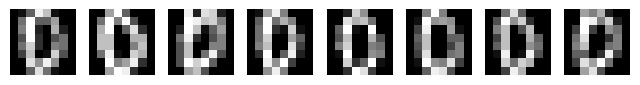

In [ ]:
# Variables y creación del dataloader
image_size = 8  # Altura/anchura de las imágenes cuadradas
batch_size = 1

transform = transforms.Compose([transforms.ToTensor()])
dataset = DigitsDataset(csv_file="optdigits.tra", transform=transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)

# Visualización de algunas muestras
plt.figure(figsize=(8, 2))
for i in range(8):
    image = dataset[i][0].reshape(image_size, image_size)
    plt.subplot(1, 8, i + 1)
    plt.axis('off')
    plt.imshow(image.numpy(), cmap='gray')
plt.show()

Ahora definimos el dispositivo cuántico que queremos usar, junto con cualquier
GPU CUDA disponibles (si están disponibles).

In [ ]:
# Parámetros cuánticos
n_qubits = 5        # Total de qubits (datos + ancillas)
depth = 6           # Profundidad del circuito
n_a_qubits = 1     # Número de qubits ancillas
n_generators = 4    # Número de sub-generadores (parches)

# Crear instancias del discriminador y generador
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
discriminator = Discriminator().to(device)
generator = PatchQuantumGenerator(n_generators, n_qubits, depth, n_a_qubits).to(device)

# Definir la función de pérdida y los optimizadores
criterion = nn.BCELoss()

lrG = 0.3  # Tasa de aprendizaje para el generador
lrD = 0.01  # Tasa de aprendizaje para el discriminador
num_iter = 600  # Número de iteraciones de entrenamiento

optimizerD = optim.SGD(discriminator.parameters(), lr=lrD)
optimizerG = optim.SGD(generator.parameters(), lr=lrG)

# Etiquetas reales y falsas
real_labels = torch.ones(batch_size, device=device)
fake_labels = torch.zeros(batch_size, device=device)

# Variables para seguimiento
counter = 0
results = []
generator_loss_values = []
discriminator_loss_values = []

# Ruido fijo para seguimiento
fixed_noise = torch.rand(8, n_qubits, device=device) * (math.pi / 2)


cpu


/usr/local/lib/python3.10/dist-packages/qiskit_machine_learning/connectors/torch_connector.py:306: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self._weights.data = torch.tensor(initial_weights, dtype=torch.float)


Ahora armando todo y ejecutando el proceso de capacitación.

Iteración: 10, Pérdida Discriminador: 1.378, Pérdida Generador: 0.656
Iteración: 20, Pérdida Discriminador: 1.372, Pérdida Generador: 0.661
Iteración: 30, Pérdida Discriminador: 1.347, Pérdida Generador: 0.671
Iteración: 40, Pérdida Discriminador: 1.335, Pérdida Generador: 0.671
Iteración: 50, Pérdida Discriminador: 1.318, Pérdida Generador: 0.676
Iteración: 60, Pérdida Discriminador: 1.320, Pérdida Generador: 0.680
Iteración: 70, Pérdida Discriminador: 1.314, Pérdida Generador: 0.667
Iteración: 80, Pérdida Discriminador: 1.310, Pérdida Generador: 0.661
Iteración: 90, Pérdida Discriminador: 1.270, Pérdida Generador: 0.678
Iteración: 100, Pérdida Discriminador: 1.244, Pérdida Generador: 0.673


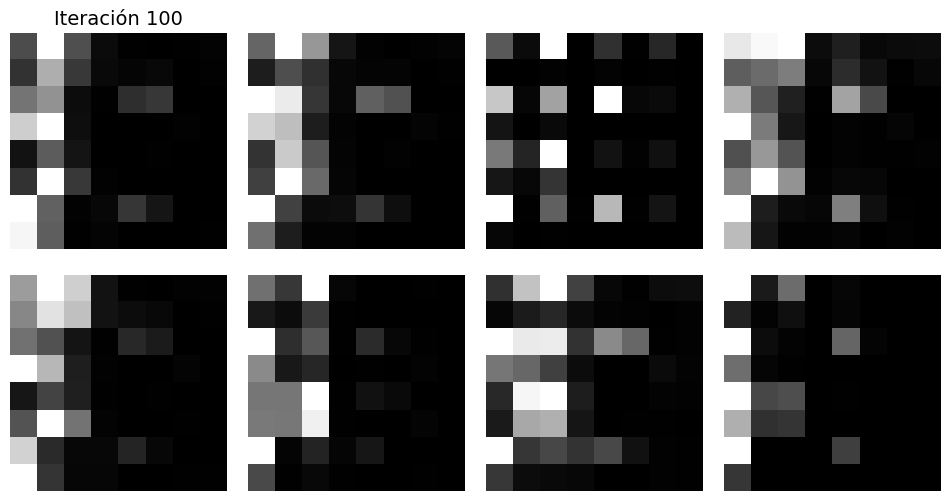

Iteración: 110, Pérdida Discriminador: 1.225, Pérdida Generador: 0.669
Iteración: 120, Pérdida Discriminador: 1.268, Pérdida Generador: 0.626
Iteración: 130, Pérdida Discriminador: 1.211, Pérdida Generador: 0.640
Iteración: 140, Pérdida Discriminador: 1.220, Pérdida Generador: 0.629
Iteración: 150, Pérdida Discriminador: 1.188, Pérdida Generador: 0.690
Iteración: 160, Pérdida Discriminador: 1.200, Pérdida Generador: 0.627
Iteración: 170, Pérdida Discriminador: 1.180, Pérdida Generador: 0.660
Iteración: 180, Pérdida Discriminador: 1.215, Pérdida Generador: 0.580
Iteración: 190, Pérdida Discriminador: 1.199, Pérdida Generador: 0.593
Iteración: 200, Pérdida Discriminador: 1.092, Pérdida Generador: 0.700


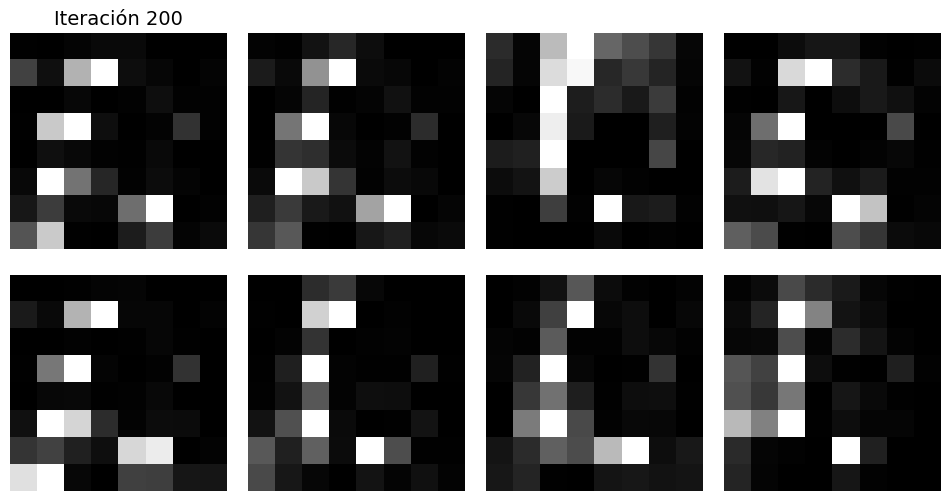

Iteración: 210, Pérdida Discriminador: 1.280, Pérdida Generador: 0.551
Iteración: 220, Pérdida Discriminador: 1.117, Pérdida Generador: 0.655
Iteración: 230, Pérdida Discriminador: 1.199, Pérdida Generador: 0.625
Iteración: 240, Pérdida Discriminador: 1.131, Pérdida Generador: 0.644
Iteración: 250, Pérdida Discriminador: 1.101, Pérdida Generador: 0.686
Iteración: 260, Pérdida Discriminador: 1.258, Pérdida Generador: 0.537
Iteración: 270, Pérdida Discriminador: 1.058, Pérdida Generador: 0.720
Iteración: 280, Pérdida Discriminador: 1.093, Pérdida Generador: 0.697
Iteración: 290, Pérdida Discriminador: 1.136, Pérdida Generador: 0.638
Iteración: 300, Pérdida Discriminador: 1.194, Pérdida Generador: 0.613


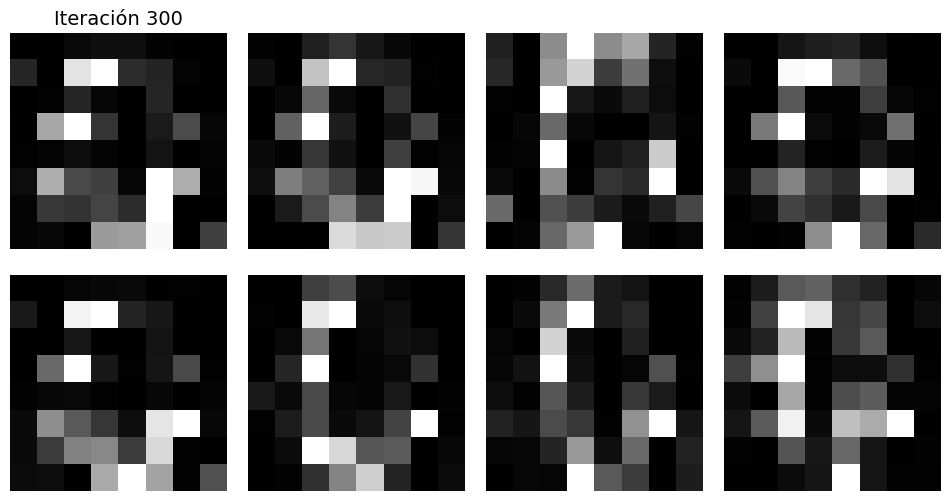

Iteración: 310, Pérdida Discriminador: 1.282, Pérdida Generador: 0.524
Iteración: 320, Pérdida Discriminador: 1.116, Pérdida Generador: 0.671
Iteración: 330, Pérdida Discriminador: 1.119, Pérdida Generador: 0.668
Iteración: 340, Pérdida Discriminador: 1.440, Pérdida Generador: 0.495
Iteración: 350, Pérdida Discriminador: 1.345, Pérdida Generador: 0.573
Iteración: 360, Pérdida Discriminador: 1.259, Pérdida Generador: 0.661
Iteración: 370, Pérdida Discriminador: 1.055, Pérdida Generador: 0.774
Iteración: 380, Pérdida Discriminador: 1.001, Pérdida Generador: 0.789
Iteración: 390, Pérdida Discriminador: 1.078, Pérdida Generador: 0.738
Iteración: 400, Pérdida Discriminador: 1.141, Pérdida Generador: 0.670


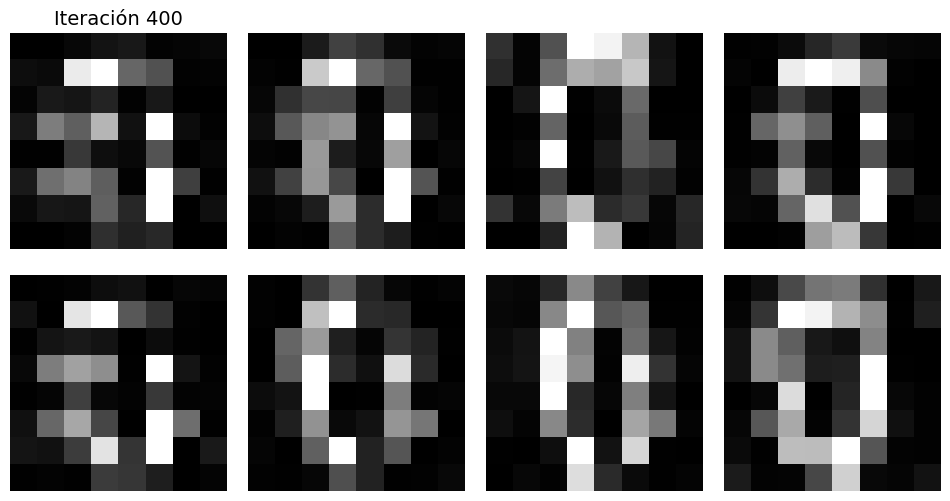

Iteración: 410, Pérdida Discriminador: 1.082, Pérdida Generador: 0.686
Iteración: 420, Pérdida Discriminador: 1.101, Pérdida Generador: 0.642
Iteración: 430, Pérdida Discriminador: 0.979, Pérdida Generador: 0.868
Iteración: 440, Pérdida Discriminador: 1.135, Pérdida Generador: 0.647
Iteración: 450, Pérdida Discriminador: 0.876, Pérdida Generador: 0.854
Iteración: 460, Pérdida Discriminador: 0.944, Pérdida Generador: 0.812
Iteración: 470, Pérdida Discriminador: 0.866, Pérdida Generador: 0.840
Iteración: 480, Pérdida Discriminador: 0.856, Pérdida Generador: 0.862
Iteración: 490, Pérdida Discriminador: 0.779, Pérdida Generador: 1.121
Iteración: 500, Pérdida Discriminador: 0.939, Pérdida Generador: 0.999


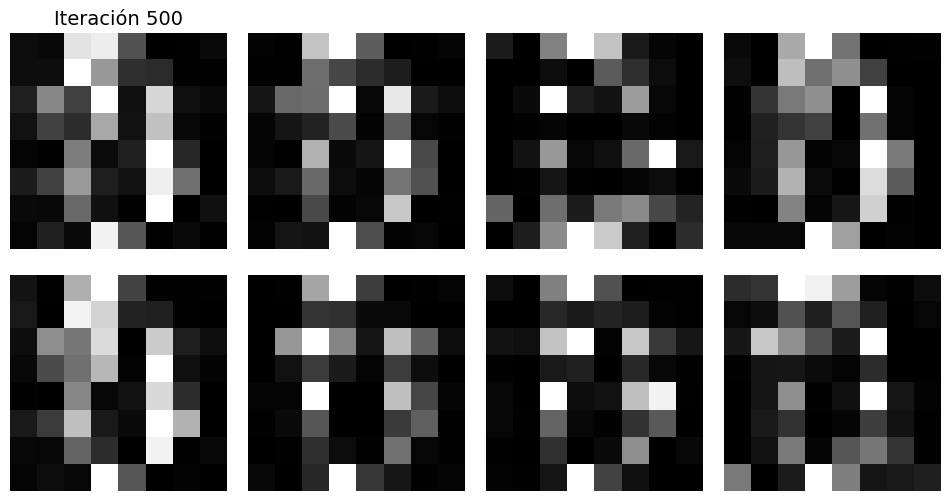

Iteración: 510, Pérdida Discriminador: 0.886, Pérdida Generador: 0.958
Iteración: 520, Pérdida Discriminador: 0.721, Pérdida Generador: 0.980
Iteración: 530, Pérdida Discriminador: 0.703, Pérdida Generador: 0.964
Iteración: 540, Pérdida Discriminador: 0.670, Pérdida Generador: 0.982
Iteración: 550, Pérdida Discriminador: 0.553, Pérdida Generador: 1.268
Iteración: 560, Pérdida Discriminador: 0.602, Pérdida Generador: 1.107
Iteración: 570, Pérdida Discriminador: 0.741, Pérdida Generador: 0.983
Iteración: 580, Pérdida Discriminador: 1.032, Pérdida Generador: 0.869
Iteración: 590, Pérdida Discriminador: 0.762, Pérdida Generador: 0.978
Iteración: 600, Pérdida Discriminador: 0.826, Pérdida Generador: 0.887


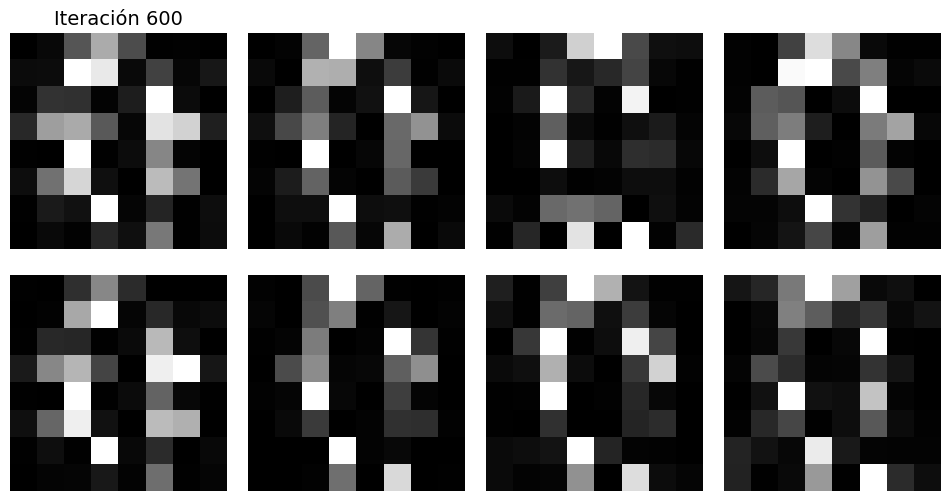

In [ ]:
# Bucle de entrenamiento
for epoch in range(num_iter):
    for i, (data, _) in enumerate(dataloader):
        # Preparar datos reales
        real_data = data.view(-1, image_size * image_size).to(device)

        # Generar datos falsos
        noise = torch.rand(batch_size, n_qubits, device=device) * (math.pi / 2)
        fake_data = generator(noise)

        # Entrenar el discriminador
        discriminator.zero_grad()
        output_real = discriminator(real_data).view(-1)
        lossD_real = criterion(output_real, real_labels)

        output_fake = discriminator(fake_data.detach()).view(-1)
        lossD_fake = criterion(output_fake, fake_labels)

        lossD = lossD_real + lossD_fake
        lossD.backward()
        optimizerD.step()

        # Entrenar el generador
        generator.zero_grad()
        output = discriminator(fake_data).view(-1)
        lossG = criterion(output, real_labels)  # Usamos etiquetas reales para el generador
        lossG.backward()
        optimizerG.step()

        # Almacenar las pérdidas
        generator_loss_values.append(lossG.item())
        discriminator_loss_values.append(lossD.item())

        counter += 1

        # Mostrar valores de pérdida cada 10 iteraciones
        if counter % 10 == 0:
            print(f'Iteración: {counter}, Pérdida Discriminador: {lossD.item():.3f}, Pérdida Generador: {lossG.item():.3f}')

        # Almacenar y visualizar imágenes cada 100 iteraciones
        if counter % 100 == 0:
            with torch.no_grad():
                test_images = generator(fixed_noise).view(8, 1, image_size, image_size).cpu()
                results.append(test_images)
                # Visualizar las imágenes generadas
                fig = plt.figure(figsize=(12, 6))
                grid = plt.GridSpec(2, 4, wspace=0.1, hspace=0.1)
                for j in range(8):
                    ax = fig.add_subplot(grid[j // 4, j % 4])
                    ax.imshow(test_images[j].squeeze(), cmap='gray')
                    ax.axis('off')
                    if j == 0:
                        ax.set_title(f'Iteración {counter}', fontsize=14)
                plt.show()

        if counter >= num_iter:
            break
    if counter >= num_iter:
        break


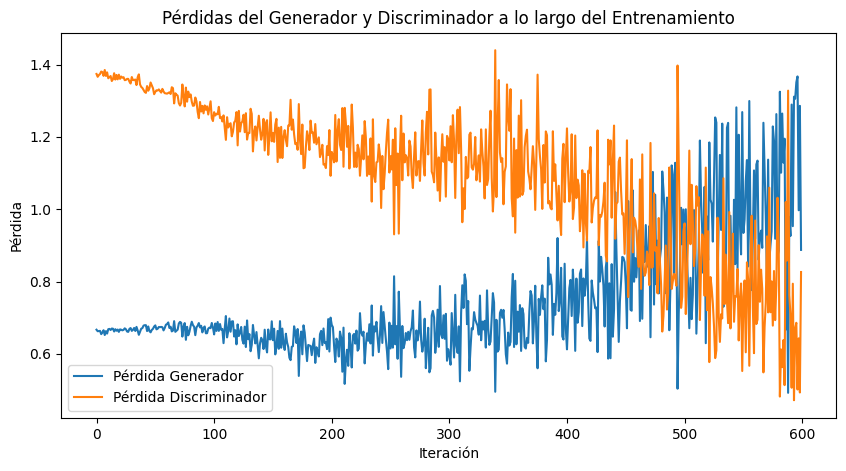

In [ ]:
# Graficar las pérdidas después del entrenamiento
plt.figure(figsize=(10,5))
plt.plot(generator_loss_values, label='Pérdida Generador')
plt.plot(discriminator_loss_values, label='Pérdida Discriminador')
plt.xlabel('Iteración')
plt.ylabel('Pérdida')
plt.legend()
plt.title('Pérdidas del Generador y Discriminador a lo largo del Entrenamiento')
plt.show()

> **Nota**  
> Es posible que hayas notado `errG = criterio(outD_fake, real_labels)` y te hayas preguntado por qué no usamos `fake_labels` en lugar de `real_labels`.
> Sin embargo, esto es simplemente un truco para poder usar la misma función "criterio" tanto para el generador como para el discriminador. Usando `etiquetas_real`
> obliga a la función de pérdida del generador a utilizar el término $\log(D(G(z))$ en lugar del término $\log(1 - D(G(z))$ de la función de pérdida de entropía cruzada binaria.

Finalmente, trazamos cómo evolucionaron las imágenes generadas a lo largo del entrenamiento.

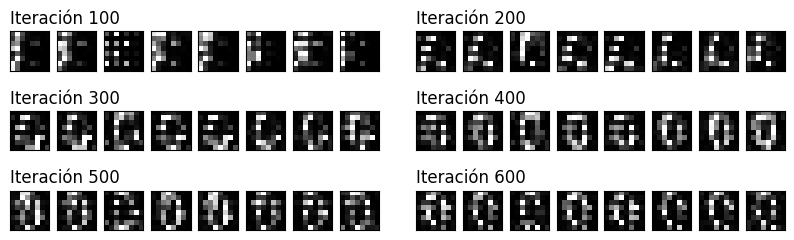

In [ ]:
# Visualizar imágenes generadas a diferentes iteraciones
fig = plt.figure(figsize=(10, 5))
outer = gridspec.GridSpec(5, 2, wspace=0.1)

for i, images in enumerate(results):
    inner = gridspec.GridSpecFromSubplotSpec(1, images.size(0),
                                             subplot_spec=outer[i])
    images = torch.squeeze(images, dim=1)
    for j, im in enumerate(images):
        ax = plt.Subplot(fig, inner[j])
        ax.imshow(im.numpy(), cmap="gray")
        ax.set_xticks([])
        ax.set_yticks([])
        if j == 0:
            ax.set_title(f'Iteración {100 + i * 100}', loc='left')
        fig.add_subplot(ax)
plt.show()
